# Downloading Required Libraries

In [1]:
!pip install nltk

# Importing Required Libraries

In [2]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gc
import spacy
from tqdm import tqdm
import zipfile
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
df=pd.read_csv('/kaggle/input/flipkart-customer-review-sentiment-dataset/flipkart_customer_review_dataset.csv')

In [4]:
df.shape

(10252, 3)

In [5]:
nltk.download('wordnet', download_dir='/kaggle/working/')
nltk.data.path.append('/kaggle/working/')

with zipfile.ZipFile('/kaggle/working/corpora/wordnet.zip','r') as file:
    file.extractall('/kaggle/working/corpora/')
    

[nltk_data] Downloading package wordnet to /kaggle/working/...


In [6]:
lemmatizer=WordNetLemmatizer()
corpus=[]
for words in tqdm(df.loc[:, 'Summary']):
    # removal of special characters and punctuations
    text=re.sub('[^a-zA-Z]'," ",words)
    # Tokenization
    tokens=nltk.word_tokenize(text)
    # Removing stopwords and applying lemmatization.
    tokens=[lemmatizer.lemmatize(words) for words in tokens if words not in stopwords.words('english')]
    # merging all tokens after all applied steps above
    text=" ".join(tokens)
    # appending processed sentence to list corpus.
    corpus.append(text)


100%|██████████| 10252/10252 [00:13<00:00, 753.62it/s]


### What happened above?
1. removal of punctuation and special characters from sentence.
2. Performing tokenization of words.
3. removing stopwords (like i, am, is, are, have, etc.) with applying lemmatization on tokens.
4. Joining all the tokens to form a sentence again.

In [7]:
df['refine_summary']=corpus

# Performing Train and Test Data Split

In [73]:
x_train, x_test, y_train, y_test=train_test_split(df['refine_summary'],df['Sentiment'], train_size=0.8, stratify=df['Sentiment'])

# Implementing TF-IDF model for vectorization

In [74]:
vector=TfidfVectorizer(ngram_range=(1,2),stop_words='english')

In [75]:
train_data=vector.fit_transform(x_train)
test_data=vector.transform(x_test)

# Performing Encoding

In [76]:
encoder=LabelEncoder()

In [77]:
Y_train=encoder.fit_transform(y_train)
Y_test=encoder.transform(y_test)

# Calculating class weights

In [78]:
from sklearn.utils import compute_class_weight
import numpy as np

In [79]:
weight=compute_class_weight('balanced', classes=np.sort(y_train.unique()), y=y_train)
weight={i:weight for i, weight in enumerate(weight)}

In [80]:
weight

{0: 2.4213167995276055, 1: 6.683781581092094, 2: 0.4102756516083846}

- 0 --> Negative
- 1 --> Neutral
- 2 --> Positive

# Creating Prediction model

In [81]:
model=LogisticRegression(class_weight=weight)

In [82]:
model.fit(train_data, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 2.4213167995276055, 1: 6.683781581092094,
                                 2: 0.4102756516083846})

In [83]:
pred=model.predict(test_data)

# Checking Performance Metrics

In [84]:
# Training accuracy
model.score(train_data, Y_train)

0.9450067064992074

In [85]:
# Test accuracy
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.65      0.80      0.72       282
           1       0.48      0.56      0.52       103
           2       0.96      0.91      0.93      1666

    accuracy                           0.88      2051
   macro avg       0.70      0.76      0.73      2051
weighted avg       0.89      0.88      0.88      2051



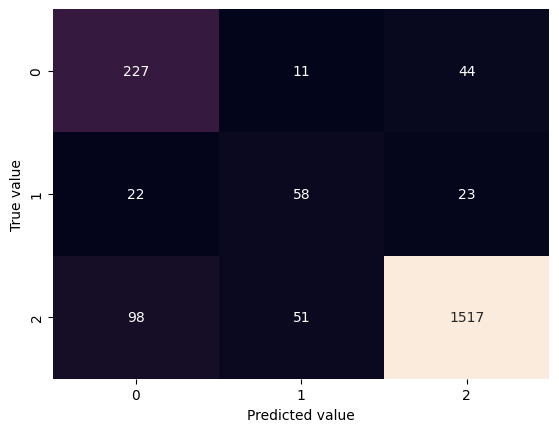

In [86]:
sns.heatmap(confusion_matrix(Y_test, pred), annot=True, fmt='.6g', cbar=False)
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.show()